## Training FNN and ResNet50 Model on Music Classification

**Note**: The functions used in this notebook require the preprocessed datasets generated from `preprocessed.ipynb`. Please ensure that you have run that notebook first prior to compiling this notebook!

The purpose of this notebook is to highlight song genre classification using two machine learning models based on an FNN framework and a ResNet framework.

All code and content contained in this notebook is the original work of Tobey Brizuela and Michael Umeh. This intellectual property is intended solely for educational and non-commercial use as part of the final project for Neural Nets and Deep Learning (CSC413) at the University of Toronto.

This material may not be reproduced, distributed, transmitted, displayed, published, or broadcast without the prior written permission of Tobey Brizuela and Michael Umeh. Unauthorized use or reproduction of this content may constitute a violation of copyright law.

For inquiries regarding the use of this material, please contact:
- Tobey Brizuela: tobey.brizuela@mail.utoronto.ca
- Michael Umeh: michael.umeh@mail.utoronto.ca

April 14, 2024

**Imports:**

In [45]:
# Importing all required methods and libraries
# --------------------------------------------

# Note: In order to run this project using CUDA (which is highly recommended!), you must have PyTorch installed with CUDA.
%matplotlib inline
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import itertools

from torch.optim import Adam
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import myutils
from sklearn.model_selection import train_test_split
import librosa
from pathlib import Path

# pip install opencv-python
import cv2 as cv

# UNUSED imports:
# ---------------
# from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.layers import Conv2D, Input
# from tensorflow.keras.models import Model
# from torchvision.models import vgg19
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import callbacks
# from tensorflow.keras import regularizers
# from sklearn.preprocessing import OneHotEncoder
# from torchvision.models.resnet import Bottleneck
# from matplotlib import cm
# import pylab
# from PIL import Image
# from matplotlib.pyplot import imshow
# from sklearn.utils.class_weight import compute_class_weight

**Constants:**

In [46]:
# Constant definitions
SPEC_HEIGHT = 216
SPEC_WIDTH = 216
SPEC_SIZE = 216
NUM_GENRES = 16

# UNUSED? Directory where mp3 are stored:
# -------------------------------
# AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Raw song data:
# --------------
# get tracks for small data set
# d_size = 'small'
# get tracks for medium data set
d_size = 'medium'
# set the directory path to the correct data set
directory_path = 'data/fma_' + d_size

## Loading in Preprocessed Dataset

Load in the **features** data

In [3]:
# Specify the directory path for loading
data_directory = 'data'

features_file_name = 'fma_features.npz'
features_file_path = os.path.join(data_directory, features_file_name)

# load the .npz file for use when we want to return to testing!
features_data_load = np.load(features_file_path)
raw_features = list(features_data_load.values())
filtered_features_data = np.array(raw_features)

Load in the **labels** data

In [4]:
# Specify the directory path for loading
data_directory = 'data'

labels_file_name = 'fma_labels.npz'
labels_file_path = os.path.join(data_directory, labels_file_name)

# load the .npz file for use when we want to return to testing!
labels_data_load = np.load(labels_file_path)
raw_labels = list(labels_data_load.values())
filtered_labels_data = np.array(raw_labels)

## FNN Model Training

Dimensionality reduction for features

In [47]:
num_components = int(filtered_features_data.shape[1]/2)

# pca dimensionality reduction, might try an autoencoder later
pca = PCA(n_components=num_components)
pca.fit(filtered_features_data)
f_data = pca.transform(filtered_features_data)

FNN Model Training Dataset Construction

In [48]:
# create pytorch dataset
dataset = TensorDataset(torch.tensor(f_data).float(), torch.tensor(filtered_labels_data))

# reproducibility
torch.manual_seed(69)

# train, test, validation split
train_size = int(0.8 * len(dataset))  # 80% 
val_size = int(0.1 * len(dataset))    # 10% 
test_size = len(dataset) - train_size - val_size  # 10%

train_dataset, val_dataset, fnn_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=80)
fnn_test_loader = DataLoader(fnn_test_dataset, batch_size=80)

FNN Accuracy Function

In [49]:
def get_accuracy(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    with torch.no_grad():
        for x, t in loader:
            # move tensors to device
            x, t = x.to(device), t.to(device)
            output = model(x)
            labels = torch.argmax(t, dim=1)
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum()
            total += x.shape[0]
    return correct / total

FNN Model Definition

In [50]:
class FNN(nn.Module):
    def __init__(self, num_components, dropout_rate=0.5, weight_decay=0.01):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(num_components, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 80)
        self.bn2 = nn.BatchNorm1d(80)
        self.fc3 = nn.Linear(80, 40)
        self.bn3 = nn.BatchNorm1d(40)
        self.fc4 = nn.Linear(40, 16)

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        # L2 regularization
        self.l2_reg = weight_decay

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = torch.softmax(self.fc4(x), dim=1)
        return x


Train FNN Model Function

In [51]:
def train_model(model, criterion, optimizer, num_epochs, device, plot_every=1000):
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    # Training loop
    for epoch in range(num_epochs):
        model.train() # train model
        for inputs, targets in train_loader:
            # move tensors to device
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad() # avoid gradient accumulation per batch
            outputs = model(inputs) # get outputs
            loss = criterion(outputs, targets.argmax(dim=1)) # compute loss
            loss.backward() # backpropagation
            optimizer.step() # update parameters

            iter_count += 1
            if iter_count % plot_every == 0:
                loss = float(loss)
                tacc = get_accuracy(model, train_dataset, device)
                vacc = get_accuracy(model, val_dataset, device)
                print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                iters.append(iter_count)
                train_loss.append(loss)
                train_acc.append(tacc)
                val_acc.append(vacc)
                
    plt.figure()
    plt.plot(iters[:len(train_loss)], train_loss)
    plt.title("Loss over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    # Move tensors back to CPU for plotting purposes!
    train_acc_cpu = [acc.cpu().numpy() for acc in train_acc]
    val_acc_cpu = [acc.cpu().numpy() for acc in val_acc]
    
    plt.figure()
    plt.plot(iters[:len(train_acc_cpu)], train_acc_cpu)
    plt.plot(iters[:len(val_acc_cpu)], val_acc_cpu)
    plt.title("Accuracy over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

Training Loop for FNN Model

Iter 1000; Loss 2.294471; Train Acc 0.512; Val Acc 0.522
Iter 2000; Loss 2.373682; Train Acc 0.553; Val Acc 0.548
Iter 3000; Loss 2.467550; Train Acc 0.562; Val Acc 0.556
Iter 4000; Loss 2.278042; Train Acc 0.574; Val Acc 0.567
Iter 5000; Loss 2.334162; Train Acc 0.587; Val Acc 0.574
Iter 6000; Loss 2.258992; Train Acc 0.589; Val Acc 0.578
Iter 7000; Loss 2.173604; Train Acc 0.630; Val Acc 0.606
Iter 8000; Loss 2.216930; Train Acc 0.648; Val Acc 0.617
Iter 9000; Loss 2.218758; Train Acc 0.650; Val Acc 0.617
Iter 10000; Loss 2.191328; Train Acc 0.661; Val Acc 0.627
Iter 11000; Loss 2.226395; Train Acc 0.667; Val Acc 0.631
Iter 12000; Loss 2.146147; Train Acc 0.667; Val Acc 0.632
Iter 13000; Loss 2.250624; Train Acc 0.668; Val Acc 0.644
Iter 14000; Loss 2.172305; Train Acc 0.670; Val Acc 0.641
Iter 15000; Loss 2.209684; Train Acc 0.669; Val Acc 0.631
Iter 16000; Loss 2.197074; Train Acc 0.678; Val Acc 0.643
Iter 17000; Loss 2.187792; Train Acc 0.678; Val Acc 0.636
Iter 18000; Loss 2.2729

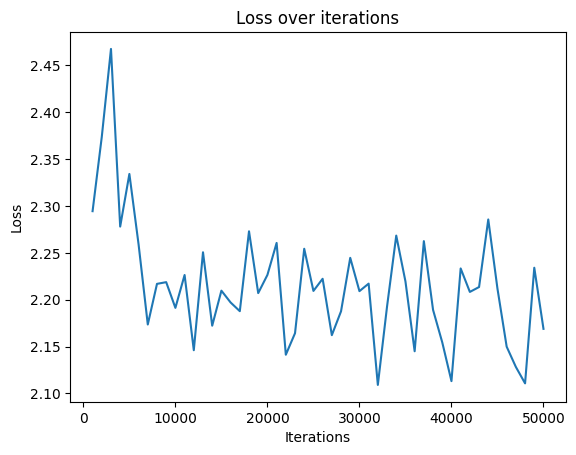

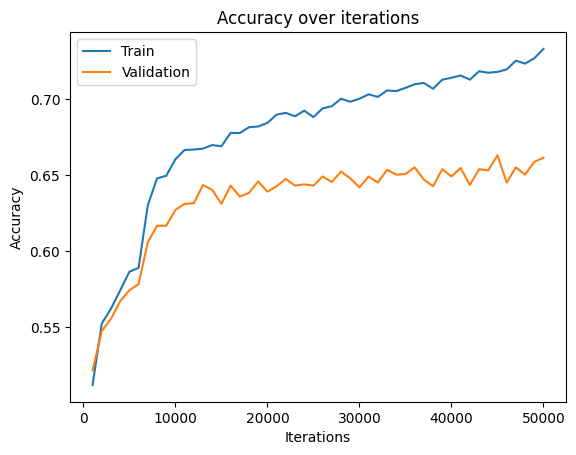

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# OLD HYPERPARAMETERS FOR OLDER VERSIONS---
# num_epochs = 25
# batch_size = 32
# lr=0.001
# # hyperparameters
# lr = 0.0006
# num_epochs = 350
# OLD HYPERPARAMETERS FOR OLDER VERSIONS---

# hyperparameters
lr = 0.0005
dropout_rate = 0.3
weight_decay = 0.01
num_epochs = 200

# instantiate model 
fnn_model = FNN(num_components=num_components, dropout_rate=dropout_rate, weight_decay=weight_decay)
fnn_model = fnn_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(fnn_model.parameters(), lr=lr)

# train the model
train_model(fnn_model, criterion, optimizer, num_epochs, device)
# test accuracy
tacc = get_accuracy(fnn_model, fnn_test_dataset, device)
print("the test accuracy of the model is {}".format(tacc))

Export the trained FNN model for safe keeping

In [52]:
# save the state of the trained fnn model to file
torch.save(fnn_model.state_dict(), 'fnn_model.pth')

Load the trained FNN model from file (in the case of not utilizing the training loop) 

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# FNN model parameters
num_components = int(filtered_features_data.shape[1]/2)
dropout_rate = 0.3
weight_decay = 0.01

# instantiate model 
fnn_model = FNN(num_components=num_components, dropout_rate=dropout_rate, weight_decay=weight_decay)
# set model to device for future model usage in the notebook
fnn_model = fnn_model.to(device)

fnn_model.load_state_dict(torch.load('fnn_model.pth'))

<All keys matched successfully>

## ResNet50 Model Training

Deleting variables to free up memory for further computational procedures

In [55]:
del pca
del f_data
del features_data_load
del raw_features
del filtered_features_data
del dataset
del train_dataset
del val_dataset
del train_loader
del val_loader

Load **normalized spectrograms**

In [56]:
# Specify the directory path
data_directory = 'data'
npz_file_name = 'fma_norm_spectrograms.npz'
npz_file_path = os.path.join(data_directory, npz_file_name)

# load the .npz file for use when we want to return to testing!
image_data_load = np.load(npz_file_path)
spectrograms = list(image_data_load.values())
image_data = np.array(spectrograms)

Define augmented ResNet50 model (allow single channel input spectrograms)

In [57]:
class ResNetChanged(nn.Module):
    def __init__(self, num_classes=16):
        super(ResNetChanged, self).__init__()
        # Load the pre-trained ResNet-50 model
        resnet = tv.models.resnet50(pretrained=True)

        # Replace the first convolutional layer with a new layer that accepts 1 input channel
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the fully connected layer with a new layer for NUM_GENRES
        resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
        
        self.resnet = resnet

    def forward(self, x):
        # Pass input through the modified ResNet model
        return self.resnet(x)

ResNet50 Training Dataset Construction

In [58]:
# our data
X_data = image_data
y_data = filtered_labels_data

# create pytorch dataset
dataset = TensorDataset(torch.tensor(X_data).unsqueeze(1).to(torch.float32), torch.tensor(y_data).to(torch.float32))

# reproducibility NOTE: (notice the same seed as FNN, so we can conduct ensemble testing later!)
torch.manual_seed(69)

# train, validation split
train_size = int(0.8 * len(dataset))  # 80%
val_size = int(0.1 * len(dataset))    # 10% 
test_size = len(dataset) - train_size - val_size  # 10%

train_dataset, val_dataset, resnet_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Set batch size
batch_size = 32

# create the resnet test dataloader for now:
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=batch_size)

# NOTE: we will create the train and validation data loader later when we
#       begin testing. This is for the sake of keeping all training-related
#       variables and objects near the training!
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)


ResNet accuracy function

In [59]:
def get_res_accuracy(model, data, device):
    # Load a new dataloader from this dataset with a larger batch size to get current model accuracy.
    data_loader = torch.utils.data.DataLoader(data, batch_size=256)
    
    # set model for evaluation
    model.eval()
    
    # counter variables
    correct = 0
    total = 0
    with torch.no_grad():
        for spectrograms, labels in data_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            
            labels_evalutation = torch.argmax(labels, dim=1)
            pred_evaluation = torch.argmax(outputs, dim=1)
            correct += (pred_evaluation == labels_evalutation).sum()
            total += spectrograms.shape[0]
    return correct / total

ResNet training function

In [60]:
def train_res_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, plot_every=10, batch_size=32):
    model.to(device)
    iters, train_losses, train_acc, val_acc = [], [], [], []  # List to store training losses for plotting
    iteration = 0
    
    for epoch in range(num_epochs):
        model.train()
        for spectrograms, labels in train_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            iteration += 1
            if iteration % plot_every == 0:
                loss = float(loss)
                tacc = get_res_accuracy(model, train_dataset, device)
                vacc = get_res_accuracy(model, val_dataset, device)
                print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iteration, loss, tacc, vacc))
                
                iters.append(iteration)
                train_losses.append(loss)
                train_acc.append(tacc)
                val_acc.append(vacc)
            # print for monitoring speed of training only!
            # print(f"Processing {iteration}")
                
    # Final loss and accuracies after training
    # ----------------------------------------
    final_loss = float(loss)  # Use the last computed loss
    final_train_acc = get_res_accuracy(model, train_dataset, device)
    final_val_acc = get_res_accuracy(model, val_dataset, device)
    print("Final Loss: %.4f" % final_loss)
    print("Final Training Accuracy: %.4f" % final_train_acc)
    print("Final Validation Accuracy: %.4f" % final_val_acc)

    # Plots after training and validation process:
    # --------------------------------------------
    plt.figure()
    plt.plot(iters[:len(train_losses)], train_losses)
    plt.title(f"Loss over iterations; epochs={num_epochs}; batch={batch_size}")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    
    # Move tensors back to CPU for plotting purposes!
    train_acc_cpu = [acc.cpu().numpy() for acc in train_acc]
    val_acc_cpu = [acc.cpu().numpy() for acc in val_acc]
    
    plt.figure()
    plt.plot(iters[:len(train_acc_cpu)], train_acc_cpu)
    plt.plot(iters[:len(val_acc_cpu)], val_acc_cpu)
    plt.title(f"Accuracy over iterations; epochs={num_epochs}; batch={batch_size}")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

**ResNet50 Grid Search for Best Hyperparameters**

In [19]:
# ------------------------------------------------------------------
# NOTE: This code is commented out for the sake of saving
#       computation time. We have already discovered the best
#       hyperparameters for epochs and batch size!
# ------------------------------------------------------------------

# plot_every = 1000

# # Setting device to GPU or CPU (whichever is available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Setting model to run on device
# resnet_model.to(device)

# # --------
# # Define grid search parameters
# num_epochs_list = [5, 10, 25]  # Values for num_epochs to test
# batch_size_list = [32, 64]  # Values for batch_size to test

# best_accuracy = 0.0
# best_params = {}

# # Nested loop for grid search
# for num_epochs, batch_size in itertools.product(num_epochs_list, batch_size_list):
#     print("---")
#     print(f"Training with num_epochs={num_epochs}, batch_size={batch_size}")
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
#     # Set model
#     resnet_model = ResNetChanged(num_classes=NUM_GENRES)  # Initialize your custom model
#     resnet_model.to(device)
    
#     optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
#     criterion = nn.CrossEntropyLoss()
    
#     # Train the model
#     train_res_model(resnet_model, criterion, optimizer, train_loader, val_loader, num_epochs, device, plot_every, batch_size)
    
#     # Evaluate validation accuracy
#     val_accuracy = get_res_accuracy(resnet_model, val_dataset, device)
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print("---")
    
#     # Check if current parameters yield the best accuracy
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_params['num_epochs'] = num_epochs
#         best_params['batch_size'] = batch_size
        
#     # Explicitly delete variables to free up memory
#     del train_loader
#     del val_loader
#     del resnet_model
#     del optimizer
#     del criterion

# # Print the best parameters found
# print(f"Best Parameters - Num Epochs: {best_params['num_epochs']}, Batch Size: {best_params['batch_size']}")
# print(f"Best Validation Accuracy: {best_accuracy:.4f}")

**Findings:**

With grid search, it was found that the best hyperparameters for the number of epochs and the batch size is:

**Number of Epochs = 25**

**Batch Size = 32**

Training Loop for ResNet50

c:\Users\Tobey\Desktop\csc413-final-project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tobey\Desktop\csc413-final-project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iter 1000; Loss 1.503283; Train Acc 0.552; Val Acc 0.551
Iter 2000; Loss 1.471281; Train Acc 0.511; Val Acc 0.492
Iter 3000; Loss 1.265727; Train Acc 0.558; Val Acc 0.549
Iter 4000; Loss 1.084173; Train Acc 0.547; Val Acc 0.533
Iter 5000; Loss 1.753174; Train Acc 0.648; Val Acc 0.610
Iter 6000; Loss 0.898941; Train Acc 0.675; Val Acc 0.647
Iter 7000; Loss 1.373972; Train Acc 0.512; Val Acc 0.463
Iter 8000; Loss 0.811358; Train Acc 0.729; Val Acc 0.630
Iter 9000; Loss 0.821583; Train Acc 0.765; Val Acc 0.635
Iter 10000; Loss 0.821304; Train Acc 0.818; Val Acc 0.631
Iter 11000; Loss 0.635778; Train Acc 0.849; Val Acc 0.617
Iter 12000; Loss 0.219765; Train Acc 0.933; Val Acc 0.623
Iter 13000; Loss 0.466439; Train Acc 0.915; Val Acc 0.598
Iter 14000; Loss 0.059400; Train Acc 0.946; Val Acc 0.599
Iter 15000; Loss 0.133989; Train Acc 0.961; Val Acc 0.607
Final Loss: 0.1413
Final Training Accuracy: 0.9495
Final Validation Accuracy: 0.6113


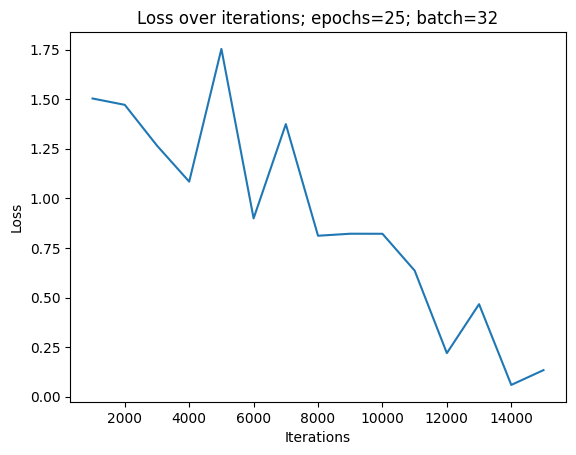

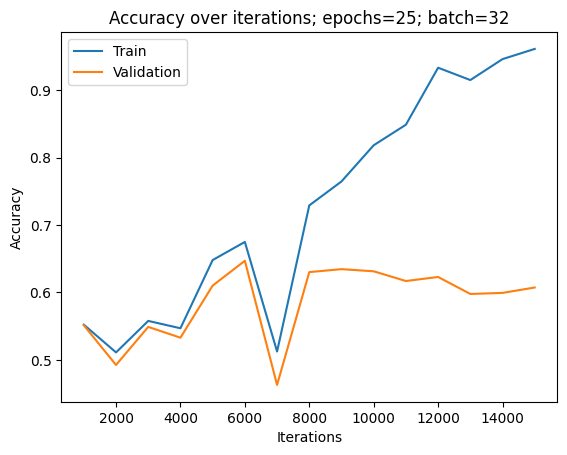

In [13]:
# Hyperparameters
num_epochs = 25
batch_size = 32
lr=0.001

# Set a datapoint for every 1000 iterations during training
plot_every = 1000

# Setting device to GPU or CPU (whichever is available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define our ResNet CNN model
resnet_model = ResNetChanged(num_classes=NUM_GENRES)

# Setting model to run on device
resnet_model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set model
resnet_model = ResNetChanged(num_classes=NUM_GENRES)  # Initialize your custom model
resnet_model.to(device)

# Set optimizer and criterion
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() 
    
# Train the model
train_res_model(resnet_model, criterion, optimizer, train_loader, val_loader, num_epochs, device, plot_every, batch_size)

Export the trained ResNet model for safe keeping

In [20]:
# save the state of the trained fnn model to file
torch.save(resnet_model.state_dict(), 'resnet_model.pth')

Load the trained ResNet model from file (in the case of not utilizing the training loop) 

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model 
resnet_model = ResNetChanged(num_classes=NUM_GENRES)
# set model to device for future model usage in the notebook
resnet_model = resnet_model.to(device)

resnet_model.load_state_dict(torch.load('resnet_model.pth'))

c:\Users\Tobey\Desktop\csc413-final\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tobey\Desktop\csc413-final\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

## Ensembling with FNN Model and ResNet50 Model

Helper function to get the predictions from a model and data:

In [62]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # we add the softmax to ensure ranges are equivalent coming from both FNN and ResNet models!
            predictions.append(torch.softmax(outputs, dim=1)) 
    return torch.cat(predictions, dim=0)

Weighted Ensemble Predictions

In [68]:
# NOTE 1: we will make predictions on our original test_loader datasets from FNN and ResNet50

# NOTE 2: Since we used the same seed for dataset construction, fnn_test_loader and
#       resnet_test_loader are equivalent datasets! Thus, we can correctly
#       evaluate the ensemble predictions

# grab the predictions from FNN and ResNet50
fnn_predictions = get_predictions(fnn_model, fnn_test_loader, device)
resnet_predictions = get_predictions(resnet_model, resnet_test_loader, device)

# weights for the ensemble (30% coming from FNN predictions, 70% coming from ResNet50 predictions)
fnn_weight = 0.3
resnet_weight = 0.7
# Weights of 30:70 split provides the highest accuracy!

# Combine predictions using weighted average
ensemble_predictions = (fnn_weight * fnn_predictions + resnet_weight * resnet_predictions) / (fnn_weight + resnet_weight)

# Perform final classification based on ensemble predictions
final_predictions = torch.argmax(ensemble_predictions, dim=1)
# Note that this is a vector of correct indices, and not the one hot encoder

def convert_one_hot_to_indices(one_hot_labels):
    return torch.argmax(one_hot_labels, dim=1)

# Grab the true labels from one of the original test loaders
true_labels = []
for _, labels in fnn_test_loader:
    true_labels.append(convert_one_hot_to_indices(labels.to(final_predictions.device)))  # Ensure labels are on the same device
    
true_labels = torch.cat(true_labels) # Concatenate all true labels into a single tensor

# Calculate accuracy
correct_predictions = (final_predictions == true_labels).sum().item()
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions

print(f"Final Ensemble Accuracy: {accuracy:.4f}")

Final Ensemble Accuracy: 0.6186
